In [72]:
from scipy.spatial import distance
import random
import pandas as pd
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import time
import os

In [73]:
def merge_lists(list1, list2):
    # Ensure all lists have the same length
    if len(list1):
        # Use a nested list comprehension to create the desired list of lists
        result = [tuple([list1[i], list2[i]]) for i in range(len(list1))]
        return result
    else:
        raise ValueError("All input lists must have the same length")


In [74]:
def generate_normal_data(num_of_points, miu=[], sigma=[]):
    list_of_generated = []
    for i in range(len(miu)):
        s = np.random.normal(miu[i], sigma[i], num_of_points)
        list_of_generated.append(s)
    return merge_lists(list_of_generated[0], list_of_generated[1]) 

In [75]:
def generate_list_labled(num_of_systems, num_of_points, miu=[], sigma=[]):
    list_label = []
    for _ in range(num_of_systems):
        list_label.append(generate_normal_data(num_of_points, miu, sigma))
    return list_label

In [76]:
def merge_list(list_of_list):
    list_final = []
    for i in list_of_list:
        list_final += i    
    return list(set(list_final))

In [77]:
def density_calc(list_base, list_point):
    n = len(list_point)
    list_base = list(set(list_base))
    list_density =[]
    list_point_final = []
    for i in list_base:
        if i in list_point:
            list_density.append(list_point.count(i)/n)
            list_point_final.append(i)
        else:
            list_density.append(0) #changed
    return  list_point_final, list_density

In [78]:
def density_calc_list(list_of_list, list_base):
    list_density = []
    for i in list_of_list:
        list_density.append(np.array([density_calc(list_base, i)[1]]).transpose())
    return list_density

In [79]:
def calculate_euclidean_distance_matrix(list1, list2):

    array1 = np.array(list1)
    array2 = np.array(list2)

    if array1.shape[1] != array2.shape[1]:
        raise ValueError("Input arrays must have the same number of dimensions")

    distance_matrix = distance.cdist(array1, array2)

    return distance_matrix


In [80]:
def calculate_exponential_matrix(distance_matrix, lamb):
    
    exponential_matrix = np.exp(-distance_matrix / lamb)
    return exponential_matrix


In [81]:
def create_blank_dataset_with_metadata(m):
    data = {
        'system num': [],
        'data points': [],
    }

    for i in range(1, m + 1):
        data[f'{i-1}'] = []
    data[f'label'] = []
    blank_dataset = pd.DataFrame(data)
    
    return blank_dataset


In [82]:
def fill_dataset_with_records(dataset, records):
    for record in records:
        dataset = pd.concat([dataset, pd.DataFrame([record])], ignore_index=True)
    return dataset

In [83]:
def make_record(list_of_list, list_p):
    records_to_be_added = []
    for i in range(len(list_of_list)):
        records_to_be_added.append({'system num': i, 'data points': list_of_list[i], 'p':list_p[i]})
        
    return records_to_be_added

In [84]:
def condensed_creator(arr):
    m = arr.shape[0]

    # Extract upper triangle indices
    upper_triangle_indices = np.triu_indices(m, k=1)

    # Use the indices to get the upper triangle elements
    upper_triangle_elements = arr[upper_triangle_indices]

    # Convert the elements to a list if needed
    upper_triangle_list = upper_triangle_elements.tolist()

    # Print or use the resulting list as needed
    return upper_triangle_list

In [85]:
def plot_dendrogram(df, save_file=False):
    columns_to_filter = [str(i) for i in range(len(df))]
    df_filter = df[columns_to_filter]
    filled_df = df_filter.fillna(0)
    matrix = filled_df.values
    matrix_final = matrix + matrix.transpose()
    
    scaled_matrix = matrix_final
    np.fill_diagonal(scaled_matrix, 0)
    
    matrix_final = condensed_creator(scaled_matrix)
    linkage_matrix = linkage(matrix_final, method='complete')
    
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, color_threshold=-np.inf, above_threshold_color='gray')
    plt.xlabel('Staffing Configurations', fontsize=15, labelpad=20)  # Set the x-axis label to 'System'
    plt.xticks([])  # Remove x-axis tick labels
    plt.ylabel('Distance', fontsize=15)
    
    if save_file:
        plt.savefig('../../results/plot_dendrogram.png', format='png', dpi=1000)
    plt.show()

In [86]:
def silhouette_score_agglomerative(df):
    columns_to_filter = [str(i) for i in range(len(df))]
    df_filter = df[columns_to_filter]
    filled_df = df_filter.fillna(0)
    matrix = filled_df.values
    matrix_final = matrix + matrix.transpose()
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    scaled_matrix = (matrix_final - min_val)
    np.fill_diagonal(scaled_matrix, 0)
    silhouette_score_list = []
    for i in range(2, len(df)):
        index_list = cluster_list_creator(df, i)
        silhouette_score_list.append(silhouette_score(scaled_matrix, index_list, metric='precomputed'))
    return silhouette_score_list

In [87]:
def entropy(matrix):
    matrix = np.array(matrix)
    non_zero_entries = matrix[matrix > 0]
    entropy_value = -np.sum(non_zero_entries * np.log(non_zero_entries))

    return entropy_value

In [88]:
def cluster_list_creator(df, num_of_clusters):
    
    columns_to_filter = [str(i) for i in range(len(df))]
    df_filter = df[columns_to_filter]
    filled_df = df_filter.fillna(0)
    matrix = filled_df.values
    matrix_final = matrix + matrix.transpose()
    
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    scaled_matrix = (matrix_final - min_val) / (max_val - min_val)
    np.fill_diagonal(scaled_matrix, 0)
    matrix_final = condensed_creator(scaled_matrix)

    linkage_matrix = linkage(matrix_final, method='complete')
    
    
    height = np.shape(linkage_matrix)[0]
    list_linkage = [[i] for i in range(len(df))]
    for i in range(height):
        list_linkage.append(list_linkage[int(linkage_matrix[i][0])] + list_linkage[int(linkage_matrix[i][1])])
        
        
    
    list_linkage_inverse = list_linkage[::-1]
    list_final = list_linkage_inverse[num_of_clusters-1:]
    list_index = []
    for i in range(len(df)):
        for j in list_final:
            if i in j:
                list_index.append(list_final.index(j))
                break

    return list_index

In [89]:
def calculate_OT_cost(p, q, reg, cost_matrix, num_iterations, stop_threshold):
    p = np.array([p]).T
    q = np.array([q]).T
    Xi = np.exp(-cost_matrix / reg)
    v_n = np.ones((Xi.shape[1], 1))
    v_old = v_n
    for _ in range(num_iterations):
        v_n = q / (Xi.T @ (p / (Xi @ v_n)))
        if np.linalg.norm(v_n  - v_old)<stop_threshold:
            break
        v_old = v_n
    diag_u = np.diagflat((p / (Xi @ v_n)))
    diag_v = np.diagflat(v_n)
    OT_plan = diag_u @ Xi @ diag_v
    OT_cost = np.multiply(OT_plan, cost_matrix).sum()
    return OT_plan

In [90]:
def fill_ot_distance(df, num_of_iterations, lambda_pen, stop_threshold):
    for i in range(len(df)):  # Iterate among rows
        for j in range(i + 1):
            cost_matrix = distance.cdist(df['data points'][i], df['data points'][j])
            min_time = time.time()

            OT_plan_test = calculate_OT_cost(
                df['p'][i], df['p'][j], lambda_pen, cost_matrix,
                num_of_iterations, stop_threshold
            )
            OT_cost_test = np.multiply(OT_plan_test, cost_matrix).sum()  # Calculate OT cost

            max_time = time.time()
            
            # Use .at to avoid chained assignment
            df.at[j, str(i)] = OT_cost_test


In [91]:
def normalize_tuples(list_of_lists):
    num_dimensions = len(list_of_lists[0][0])  # Get the number of dimensions from the first tuple
    
    # Extract all values for each dimension
    all_values = [[] for _ in range(num_dimensions)]
    for sublist in list_of_lists:
        for i, t in enumerate(sublist):
            for j in range(num_dimensions):
                all_values[j].append(t[j])
    
    # Compute the minimum and maximum values for each dimension
    min_values = [min(dim_values) for dim_values in all_values]
    max_values = [max(dim_values) for dim_values in all_values]
    # Normalize each dimension of each tuple
    normalized_list_of_lists = []
    for sublist in list_of_lists:
        normalized_sublist = []
        for t in sublist:
            normalized_t = tuple((t[j] - min_values[j]) / (max_values[j] - min_values[j]) for j in range(num_dimensions))
            normalized_sublist.append(normalized_t)
        normalized_list_of_lists.append(normalized_sublist)
    
    return normalized_list_of_lists, np.array(min_values), np.array(max_values)



### Simulation output analysis

In [92]:
# Here we import our data (both inputs and outputs)
with open('../../data/my_list.txt', 'r') as f:
    # Read lines from the file and parse tuples of floats
    list_sim_outputs_raw = [eval(line.strip()) for line in f]

points = np.loadtxt('../../data/points.txt')
input_list = [tuple(point) for point in points]

In [93]:
list_base = merge_list(list_sim_outputs_raw)


In [94]:
# Here we take list_sim_outputs and generate p vector and also the unrepeated list_sim_ouputs
# print(list_sim_outputs_raw)
list_sim_outputs = []
p_list = []
for i in list_sim_outputs_raw:
    list_sim_outputs.append(density_calc(i, i)[0])
    p_list.append(density_calc(i, i)[1])
    


### Normalized

In [95]:

# Example usage:
normalized_list_sim_outputs = normalize_tuples(list_sim_outputs)[0]
min_norm_values =  normalize_tuples(list_sim_outputs)[1]
max_norm_values =  normalize_tuples(list_sim_outputs)[2]

In [96]:
# we store both normalized and de normalized points
m = len(normalized_list_sim_outputs)
blank_df = create_blank_dataset_with_metadata(m)
df = fill_dataset_with_records(blank_df, make_record(normalized_list_sim_outputs, p_list))
# Display the filled dataset
print("Filled Dataset:")
df['data points real'] = list_sim_outputs
df['input points'] = input_list
# df['data points'][0]

Filled Dataset:


In [97]:
lambda_value = 0.5
fill_ot_distance(df, 1000, lambda_value, stop_threshold=10**-9)

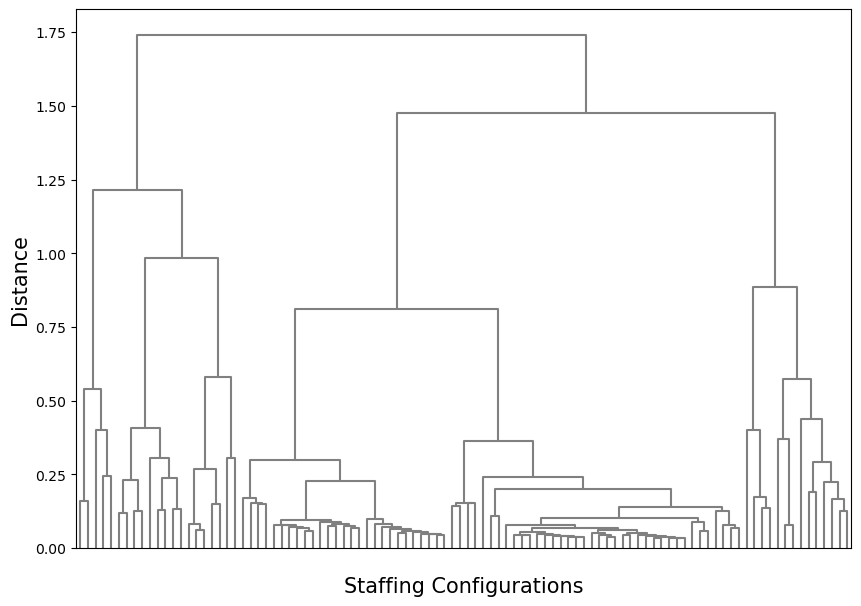

In [98]:
plot_dendrogram(df, save_file=True)

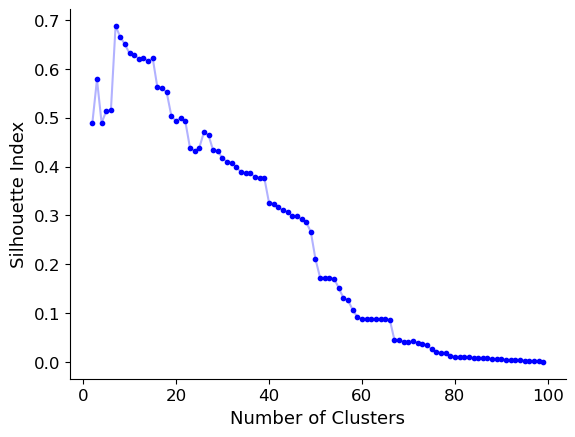

In [99]:
import matplotlib.pyplot as plt

# Your data
y_values = silhouette_score_agglomerative(df)  # Example data, replace with your own

# Specify the x-axis values
x_values = [i + 2 for i in range(len(y_values))]  # Example x-axis values, replace with your own

# Plotting
fig, ax = plt.subplots()
ax.plot(x_values, y_values, marker='.', color='b', linestyle='-', alpha=0.3)  # Set line alpha for transparency
ax.scatter(x_values, y_values, color='b', marker='.', label='Silhouette Score')  # Scatter plot for dots

# Increase text size
ax.set_xlabel('Number of Clusters', fontsize=13)  # Replace with your own x-axis label
ax.set_ylabel('Silhouette Index', fontsize=13)  # Replace with your own y-axis label
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove gridlines
ax.grid(False)

# Remove upper and right borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Save the plot
plt.savefig('../../results/plot_silhouette_optimization.png', format='png', dpi=500)

# Show the plot
plt.show()


In [100]:
from scipy.cluster import hierarchy

# Assuming dist_matrix is your distance matrix
# Perform hierarchical clustering using the distance matrix
columns_to_filter = [str(i) for i in range(len(df))]
df_filter = df[columns_to_filter]
filled_df = df_filter.fillna(0)
matrix = filled_df.values
diagonal = np.diagonal(matrix)
matrix_final = matrix + matrix.transpose() 


np.fill_diagonal(matrix_final, 0)

#until here, we will have the positive distance matrix scaled to zero. 


# Below we get the linkage matrix, which will be used in many parts
upper_triangle_flat = matrix_final[np.triu_indices_from(matrix_final, k=1)]    
Z = hierarchy.linkage(upper_triangle_flat, method='complete') 


In [101]:
n_clusters = 7  # Specify the number of clusters you want

# Get cluster assignments for each data point based on the number of clusters
clusters = hierarchy.fcluster(Z, n_clusters, criterion='maxclust')



def replace_4_and_5(numbers):
    return np.array([5 if num == 4 else 4 if num == 5 else num for num in numbers])

# Example usage
clusters = replace_4_and_5(clusters)
df['cluster'] = clusters

In [102]:
blank_df_clusters = create_blank_dataset_with_metadata(n_clusters)
records_to_be_added =[]
for i in range(1,n_clusters+1):
        records_to_be_added.append({'cluster num': i, 'p':0})
df_clusters = fill_dataset_with_records(blank_df_clusters, records_to_be_added)    


In [103]:
def proximal_mapping(a, gradient, t0_beta):
    # Proximal mapping using Kullback-Leibler divergence as the Bregman divergence


    a_tilde = a * np.exp(-t0_beta * gradient)
    a_tilde /= np.sum(a_tilde)
    return a_tilde

def opt_a(X, Y_list, b_list, t0, tol=1e-9, max_iter=1000):
    n = X.shape[0]
    N = len(Y_list)
    
    # Form all n x mi matrices Mi
    M_list = [np.linalg.norm(X[:, np.newaxis] - Y, axis=2) for Y in Y_list]
#     Initialize a_hat and a_tilde
    a_hat  = (np.ones(n) / n).reshape((n, 1))
    a_tilde = a_hat
    t = 3
    converged = False
    while not converged and t < max_iter:
        beta = (t + 1) / 2
        a = (1 - beta**-1) * a_hat + beta**-1 * a_tilde
        
        # Form subgradient alpha
        alpha_list = [calculate_OT_cost(a, b_list[i], 0.5,M_list[i], num_iterations=100, stop_theshold=10**-9)[1] for i in range(len(b_list))]
        alpha = np.mean(alpha_list, axis=0)
        # Update a_tilde using the proximal mapping
        t0_beta = t0 * beta
        a_tilde = proximal_mapping(a, alpha, t0_beta)
#         # Update a_hat
        a_hat = (1 - beta**-1) * a_hat + (beta**-1) * a_tilde
        
#         # Check convergence
        if np.linalg.norm(a_tilde - a_hat) < tol:
            converged = True
        
        t += 1
    return a_hat

def find_barycenter(X, Y_list, b_list, t0, theta, tol=1e-9, max_iter=1000):
    iter_num = 1
    while iter_num< max_iter:
        n = X.shape[0]
        N = len(Y_list)
        M_list = [np.linalg.norm(X[:, np.newaxis] - Y, axis=2) for Y in Y_list]
        
        
        a_update = opt_a(X, Y_list, b_list, t0, tol=1e-2, max_iter=30)

        
        T_list = [calculate_OT_cost(a_update, b_list[i], 0.2,M_list[i], num_iterations=50, stop_theshold=10**-2)[0] for i in range(len(b_list))]
        YT_list = [T_list[i] @ Y_list[i] for i in range(len(Y_list))]
        YT_ave = np.mean(YT_list, axis=0)
        X_old = X
        X = (1-theta) * X + theta * (np.diag((a_update**-1).T[0]) @ YT_ave)
        if np.linalg.norm(X - X_old) < tol:
            return X, a_update
        iter_num += 1 

    return X, a_update

def calculate_OT_cost(p, q, reg, cost_matrix, num_iterations, stop_theshold):
    Xi = np.exp(-cost_matrix / reg)
    v_n = np.ones((Xi.shape[1], 1))
    v_old = v_n
    for _ in range(num_iterations):
        v_n = q / (Xi.T @ (p / (Xi @ v_n)))
        if np.linalg.norm(v_n  - v_old)<stop_theshold:
            break
        v_old = v_n
    diag_u = np.diagflat((p / (Xi @ v_n)))
    diag_v = np.diagflat(v_n)
    OT_plan = diag_u @ Xi @ diag_v
    OT_cost = np.multiply(OT_plan, cost_matrix).sum()
    return OT_plan, p / (Xi @ v_n), v_n

In [105]:
def denormalize(matrix, min_values, max_values):
    return matrix * (max_values - min_values) + min_values




min_values_all = []
max_values_all = []
list_bary_X = []
list_bary_prob = []
list_inputs_cluster = []
list_p_cluster_new = []
list_sup_cluster_new = []
list_sup_cluster_real_new = []
for i in range(1, len(df_clusters)+1):

    df_test  = df[df['cluster']==i]
    list_column = df_test['data points real']
    
    list_sim_outputs_cluster = list_column.tolist()
    min_values_all.append(normalize_tuples(list_sim_outputs_cluster)[1])
    max_values_all.append(normalize_tuples(list_sim_outputs_cluster)[2])
    list_sim_outputs_cluster =  normalize_tuples(list_sim_outputs_cluster)[0]
    list_base_cluster = merge_list(list_sim_outputs_cluster)
    list_of_arrays = [np.array(inner_list) for inner_list in list_sim_outputs_cluster]
    X = np.random.rand(100, 5) # change p
    b_list = [(np.ones(len(list_sim_outputs_cluster[i])) / len(list_sim_outputs_cluster[i]) ).reshape((len(list_sim_outputs_cluster[i]), 1)) for i in range(len(list_sim_outputs_cluster))]
    t0 = 0.005
    theta = 0.005
    reg = 0.5
    bary_X, bary_a = find_barycenter(X, list_of_arrays, b_list, t0, theta, tol=1e-2*0.9, max_iter=400)
    list_bary_X.append(bary_X)
    list_bary_prob.append(bary_a)
    
    
    list_column_real = df_test['data points real']
    list_sim_outputs_cluster_real = list_column_real.tolist()
    list_base_cluster_real = merge_list(list_sim_outputs_cluster_real)
    
    list_column_input = df_test['input points']
    list_sim_inputs_cluster = list_column_input.tolist()
    
    cost_matrix_cluster = distance.cdist(list_base_cluster, list_base_cluster)
    density_list_cluster = density_calc_list(list_sim_outputs_cluster, list_base_cluster)
    list_sup_cluster_new.append(list_base_cluster)
    list_sup_cluster_real_new.append(list_base_cluster_real)
    list_inputs_cluster.append(list_sim_inputs_cluster)
    # here its real though nt mentioned 



In [106]:
matrices = list_bary_X
matrices = [denormalize(matrices[i], min_values_all[i], max_values_all[i]) for i in range(len(matrices))]

# Corresponding probability masses
prob_masses = list_bary_prob

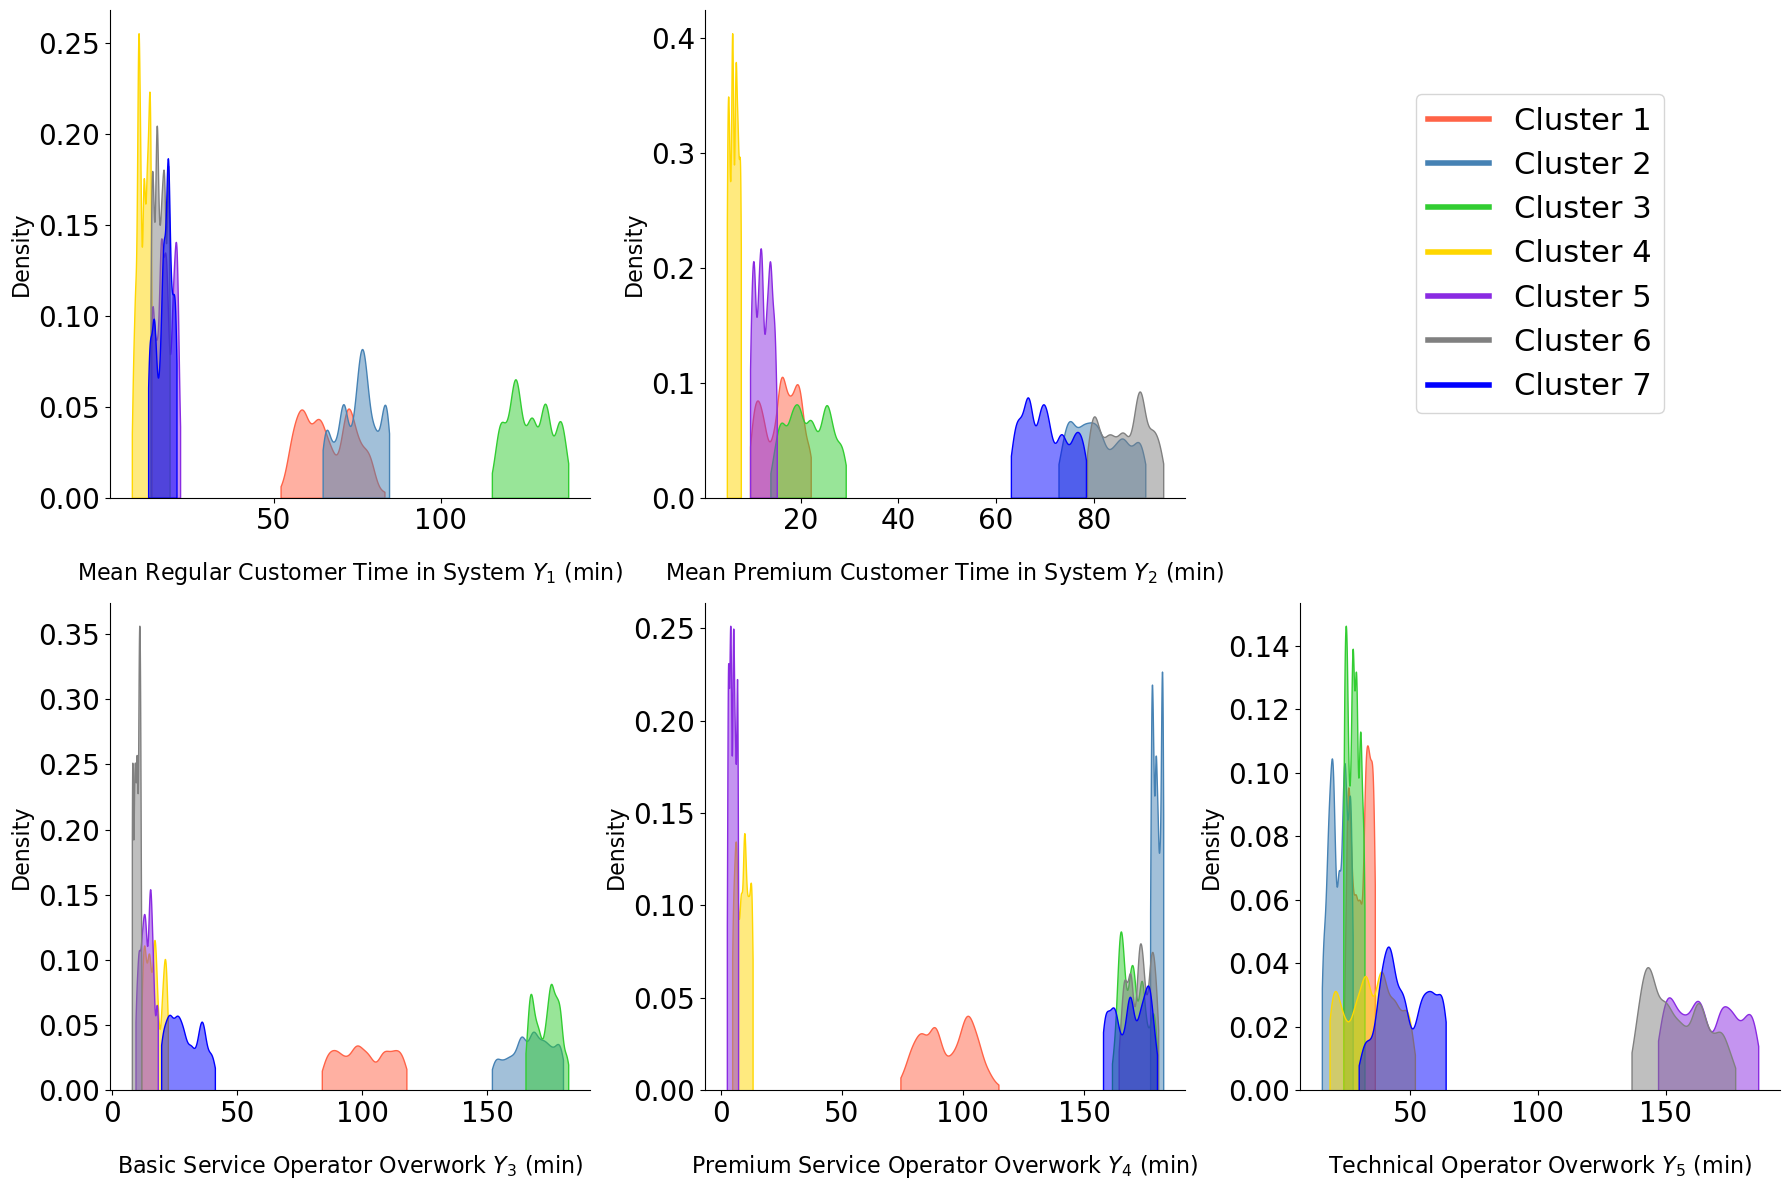

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def plot_selected_distributions(data_points_list, prob_masses_list, selected_indices, x_labels):
    matrices = data_points_list
    prob_masses = prob_masses_list
    dimension = matrices[0].shape[1]

    # Define custom colors (you can change these to any valid color)
    custom_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2', 'gray', "blue"]

    # Determine number of rows and columns for subplots
    nrows = 2
    ncols = 3  # Three columns as specified

    # Create subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12))

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    for dim in range(dimension):
        for idx in selected_indices:
            matrix = matrices[idx]
            points = matrix[:, dim]
            probs = prob_masses[idx]

            # Select custom color based on the index
            color = custom_colors[selected_indices.index(idx) % len(custom_colors)]
            label = f'Cluster {idx+1}'

            # Skip the last plot in the first row (legend position)
            plot_position = dim if dim < 2 else dim + 1

            # Plot KDE using seaborn with fill and transparency, and custom color
            sns.kdeplot(points, ax=axs[plot_position], fill=True, alpha=0.5, label=label, color=color, clip=(min(points), max(points)), bw_adjust=0.5)

            # Set axis labels and increase their font size, use labelpad to control label positioning
            axs[plot_position].set_xlabel(x_labels[dim], fontsize=16, labelpad=18)  # Larger x-axis label with extra padding
            axs[plot_position].set_ylabel('Density', fontsize=16)

            # Increase the font size of tick labels
            axs[plot_position].tick_params(axis='both', labelsize=20)

            # Remove the upper and right border
            axs[plot_position].spines['top'].set_visible(False)
            axs[plot_position].spines['right'].set_visible(False)

    # Create a legend in the last plot space of the first row
    legend_ax = axs[2]  # The third plot space in the first row
    legend_ax.axis('off')
    handles = [
        Line2D([0], [0], color=custom_colors[i % len(custom_colors)], lw=4, label=f'Cluster {selected_indices[i] + 1}')
        for i in range(len(selected_indices))
    ]
    legend_ax.legend(handles=handles, loc='center', fontsize=22)  # Increased legend font size

    # Adjust space between subplots
    plt.subplots_adjust(hspace=0.4)  # Increase vertical space between subplots

    plt.tight_layout()
    plt.savefig('../../results/plot_pdfs_custom_colors.png', format='png', dpi=300)
    plt.show()

# Example usage:
# Assuming matrices and list_bary_prob are defined
x_labels = [
    'Mean Regular Customer Time in System $Y_1$ (min)',
    'Mean Premium Customer Time in System $Y_2$ (min)',
    'Basic Service Operator Overwork $Y_3$ (min)',
    'Premium Service Operator Overwork $Y_4$ (min)',
    'Technical Operator Overwork $Y_5$ (min)'
]


plot_selected_distributions(matrices, list_bary_prob, [0, 1, 2, 3, 4, 5, 6], x_labels)


In [108]:
df_clusters['input points'] = list_inputs_cluster
df_clusters['data points'] = list_sup_cluster_new
df_clusters['data points real'] = list_sup_cluster_real_new
df_clusters['p'] = list_bary_prob


In [109]:
def find_min_cost(tuples_list, cost_tuple):
    """
    Find the tuple (x1, x2, x3) from tuples_list that minimizes the cost function ax1 + bx2 + cx3.

    Parameters:
    tuples_list (list of tuples): A list of tuples, where each tuple contains three values (x1, x2, x3).
    cost_tuple (tuple): A tuple containing three costs (a, b, c).

    Returns:
    tuple: The tuple (x1, x2, x3) that gives the minimum cost.
    float: The minimum cost value.
    """
    a, b, c = cost_tuple
    min_cost = float('inf')
    min_tuple = None

    for t in tuples_list:
        x1, x2, x3 = t
        cost = a * x1 + b * x2 + c * x3

        if cost <= min_cost:
            print(cost, t)
            min_cost = cost
            min_tuple = t

    return min_tuple, min_cost

# Example usage:

cost_tuple = (1, 2, 3)

min_tuple, min_cost = find_min_cost(list_inputs_cluster[3],(4,1,1))
print(f"The tuple that gives the minimum cost is: {min_tuple}")
print(f"The minimum cost is: {min_cost}")


130.0 (27.0, 5.0, 17.0)
106.0 (19.0, 21.0, 9.0)
76.0 (9.0, 23.0, 17.0)
70.0 (7.0, 28.0, 14.0)
The tuple that gives the minimum cost is: (7.0, 28.0, 14.0)
The minimum cost is: 70.0


In [110]:

def sort_tuples_by_cost(tuples_list, cost_tuple):
    """
    Sort the tuples (x1, x2, x3) from tuples_list based on the cost function ax1 + bx2 + cx3 in ascending order.

    Parameters:
    tuples_list (list of tuples): A list of tuples, where each tuple contains three values (x1, x2, x3).
    cost_tuple (tuple): A tuple containing three costs (a, b, c).

    Returns:
    list: A list of tuples sorted by their cost in ascending order.
    """
    a, b, c = cost_tuple

    # Calculate cost for each tuple and store it along with the tuple in a list
    tuples_with_cost = [(t, a * t[0] + b * t[1] + c * t[2]) for t in tuples_list]

    # Sort the list of tuples by their cost in ascending order
    sorted_tuples_with_cost = sorted(tuples_with_cost, key=lambda x: x[1])

    # Extract the sorted tuples from the list
    sorted_tuples = [t[0] for t in sorted_tuples_with_cost]

    return sorted_tuples


# min_tuple, min_cost = find_min_cost(list_inputs_cluster[3],(4,1,1))
# print(f"The tuple that gives the minimum cost is: {min_tuple}")
# print(f"The minimum cost is: {min_cost}")
# (11.0, 27.0, 11.0) * ()
sorted_tuples = sort_tuples_by_cost(list_inputs_cluster[3], (4,1,1))
print("The tuples sorted by cost in ascending order are:")
print(sorted_tuples)
print(len(sorted_tuples))

The tuples sorted by cost in ascending order are:
[(7.0, 28.0, 14.0), (9.0, 23.0, 17.0), (9.0, 19.0, 21.0), (10.0, 30.0, 9.0), (11.0, 27.0, 11.0), (12.0, 18.0, 19.0), (13.0, 14.0, 22.0), (13.0, 23.0, 13.0), (13.0, 21.0, 15.0), (14.0, 10.0, 25.0), (14.0, 16.0, 19.0), (15.0, 25.0, 9.0), (15.0, 8.0, 26.0), (16.0, 17.0, 16.0), (16.0, 20.0, 13.0), (17.0, 12.0, 20.0), (17.0, 3.0, 29.0), (18.0, 9.0, 22.0), (18.0, 15.0, 16.0), (19.0, 21.0, 9.0), (19.0, 4.0, 26.0), (20.0, 11.0, 18.0), (21.0, 17.0, 11.0), (22.0, 10.0, 17.0), (22.0, 6.0, 21.0), (23.0, 2.0, 24.0), (23.0, 7.0, 19.0), (24.0, 12.0, 13.0), (25.0, 3.0, 21.0), (26.0, 14.0, 9.0), (27.0, 5.0, 17.0), (27.0, 8.0, 14.0), (29.0, 7.0, 13.0), (30.0, 9.0, 10.0), (31.0, 1.0, 17.0), (32.0, 3.0, 14.0), (33.0, 6.0, 10.0), (36.0, 1.0, 12.0)]
38


In [111]:
cluster_num = 4
# df_test  = df[df['input points']==(7.0,28.0,14.0)]
df_test = df[(df['input points'] !=  (7.0, 28.0, 14.0)) & (df['input points'] !=  (9.0, 23.0, 17.0)) &(df['input points'] !=   (12.0, 18.0, 19.0)) & (df['cluster'] == 4)]
list_column = df_test['data points real'].tolist()
list_p_pdf = df_test['p'].tolist()
df_test_2 = df[df['input points'] ==   (7.0, 28.0, 14.0)]
list_column.append(df_test_2['data points real'].tolist()[0])
list_p_pdf.append(df_test_2['p'].tolist()[0])

df_test_2 = df[df['input points'] ==   (9.0, 23.0, 17.0)]
list_column.append(df_test_2['data points real'].tolist()[0])
list_p_pdf.append(df_test_2['p'].tolist()[0])

df_test_2 = df[df['input points'] ==    (12.0, 18.0, 19.0)]
list_column.append(df_test_2['data points real'].tolist()[0])
list_p_pdf.append(df_test_2['p'].tolist()[0])

list_column.append(matrices[cluster_num-1].tolist())
list_p_pdf.append(list_bary_prob[cluster_num-1])

print(len(list_column[-1]))
print(len(prob_masses[cluster_num-1]))
# print(len(list_bary_prob_list[cluster_num-1][0]))

100
100


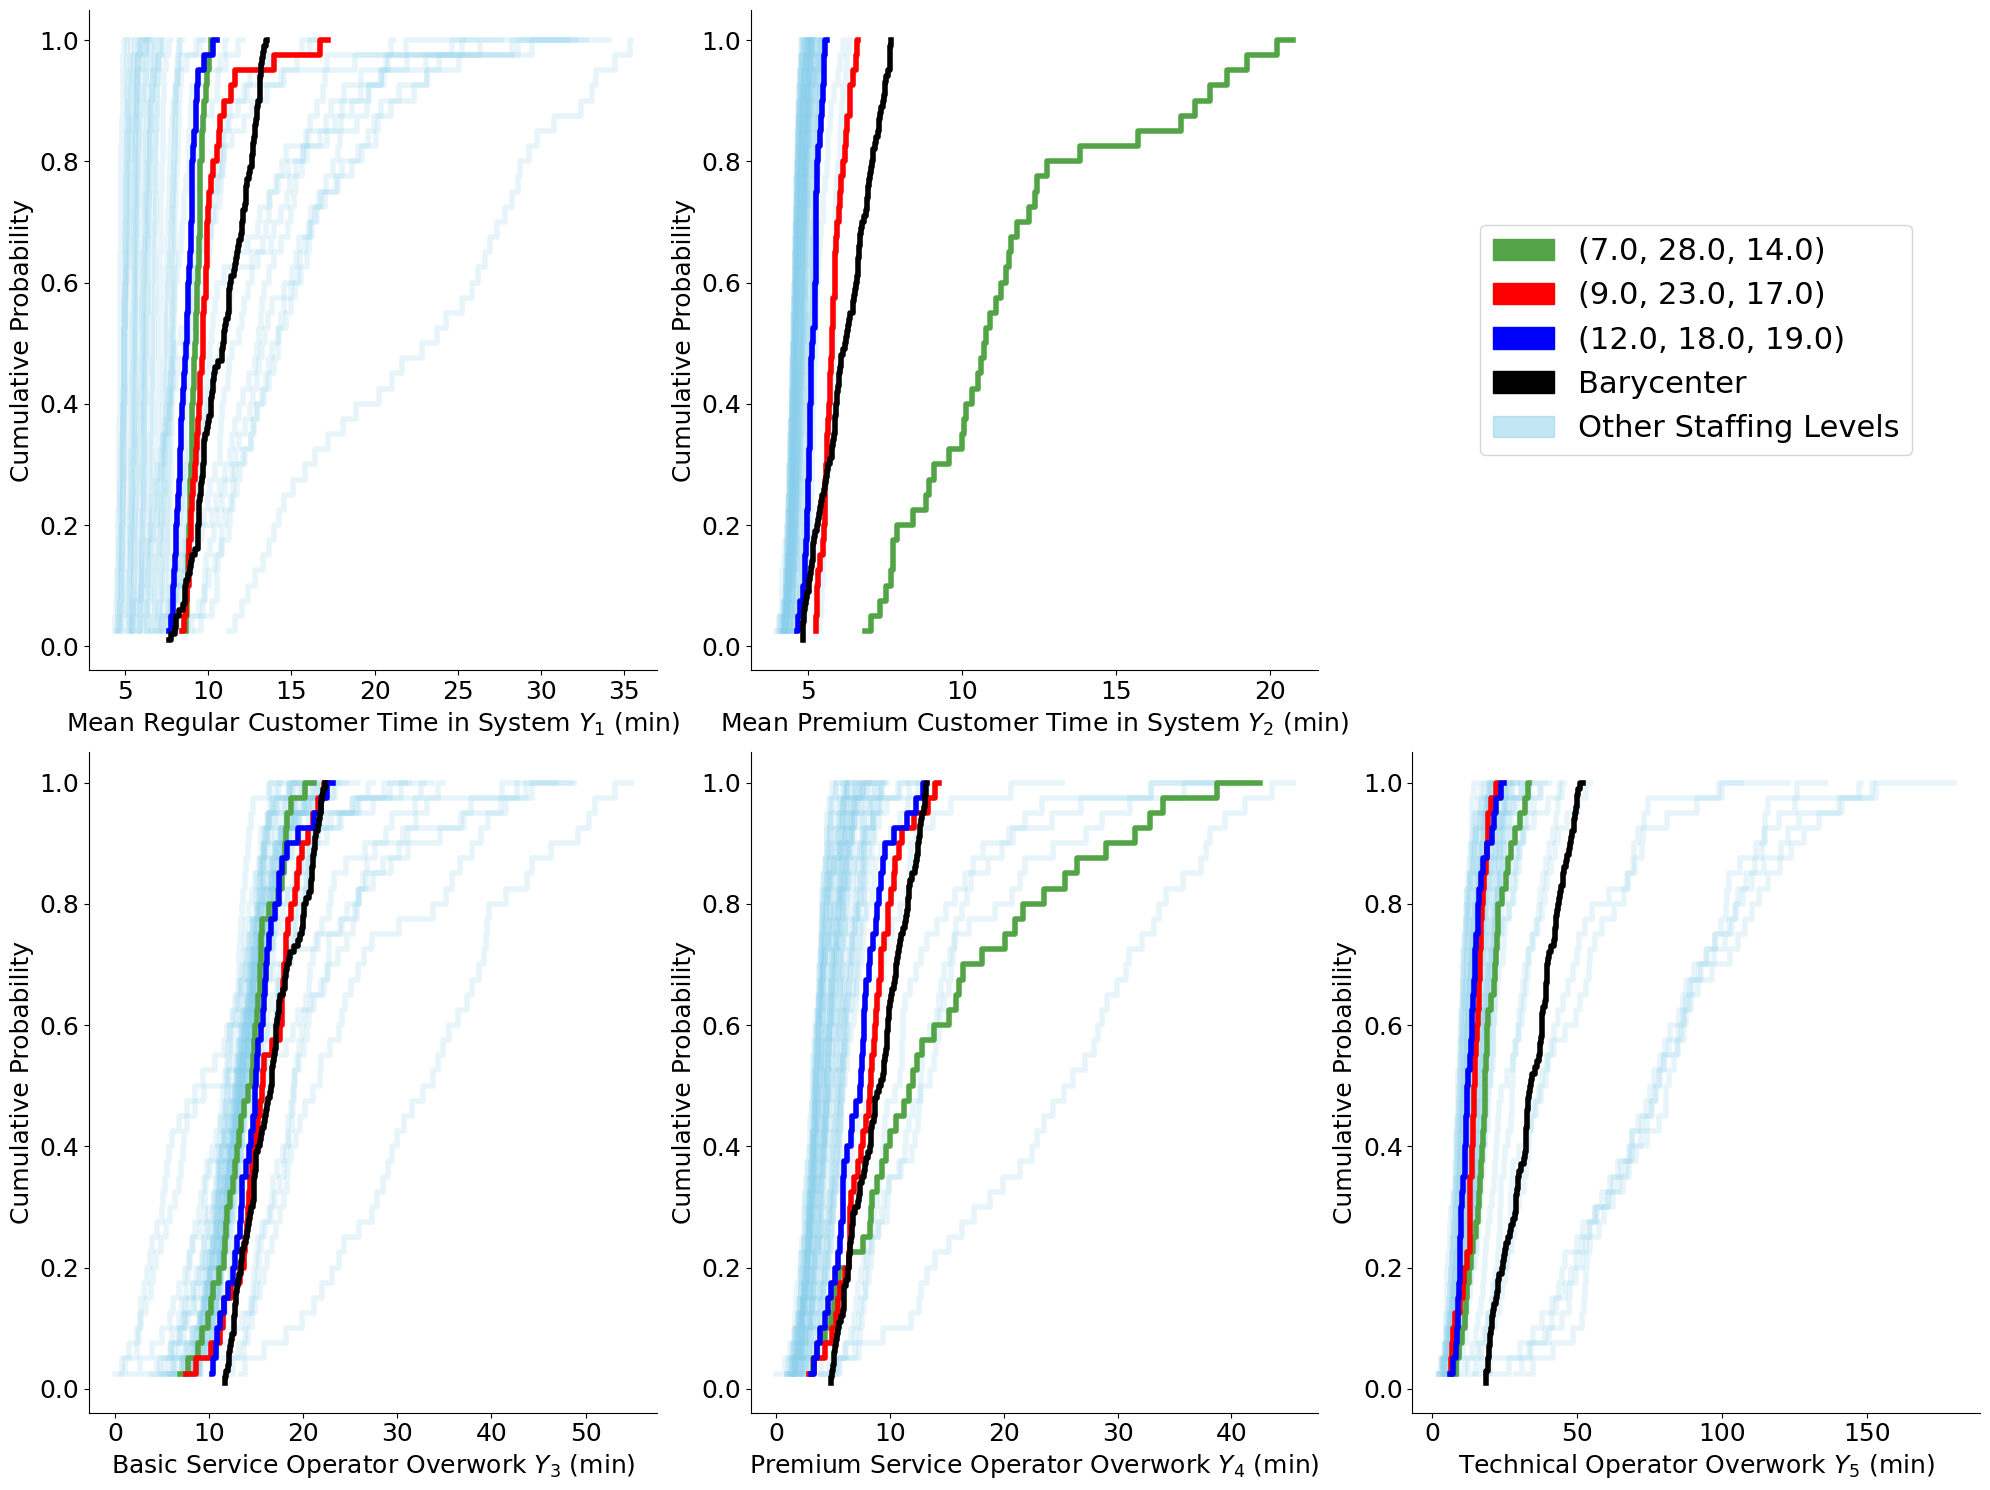

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

def plot_marginal_cdfs(data_points_list, prob_masses_list, list_of_labels=None, save_file=False):
    num_dimensions = len(data_points_list[0][0])  # Assuming all data points have the same number of dimensions

    # Create a figure and a grid spec
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1])

    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 0]),
           fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2])]
    legend_ax = fig.add_subplot(gs[0, 2])

    common_color = 'skyblue'
    second_last_color = '#52a447'  # Changed from black to orange
    third_last_color = 'red'
    fourth_last_color = 'blue'
    last_color = 'black'

    num_clusters = len(data_points_list)

    for dim in range(num_dimensions):
        for i, (data_points, prob_masses) in enumerate(zip(data_points_list, prob_masses_list)):
            values = np.array(data_points)[:, dim]
            if i == num_clusters - 1:
                color = last_color
                alpha = 1
            elif i == num_clusters - 2:
                color = fourth_last_color
                alpha = 1
            elif i == num_clusters - 3:
                color = third_last_color
                alpha = 1
            elif i == num_clusters - 4:
                color = second_last_color
                alpha = 1
            else:
                color = common_color
                alpha = 0.2
            
            # Compute and plot CDF
            sorted_indices = np.argsort(values)
            sorted_values = values[sorted_indices]
            sorted_weights = np.array(prob_masses).flatten()[sorted_indices]  # Ensure prob_masses is flattened
            cdf = np.cumsum(sorted_weights)

            axs[dim].step(sorted_values, cdf, where='mid', color=color, label=f'Cluster {i + 1}', alpha=alpha, linewidth=4)
            
            # Set axis labels with increased font size and bold
            axs[dim].set_xlabel(f'{list_of_labels[dim] if list_of_labels else f"Dimension {dim + 1}"} (min)', fontsize=18)
            axs[dim].set_ylabel('Cumulative Probability', fontsize=18)

            # Increase the font size of x-ticks and y-ticks
            axs[dim].tick_params(axis='x', labelsize=18)
            axs[dim].tick_params(axis='y', labelsize=18)

            # Remove the upper and right border
            axs[dim].spines['top'].set_visible(False)
            axs[dim].spines['right'].set_visible(False)

    # Create a legend in the first row's last plot space
    legend_ax.axis('off')
    handles = [
       
        mpatches.Patch(color=second_last_color, label='(7.0, 28.0, 14.0)'),
        mpatches.Patch(color=third_last_color, label='(9.0, 23.0, 17.0)'),
        mpatches.Patch(color=fourth_last_color, label='(12.0, 18.0, 19.0)'),
        mpatches.Patch(color=last_color, label='Barycenter'),
         mpatches.Patch(color=common_color, alpha=0.5, label='Other Staffing Levels')
    ]
    legend_ax.legend(handles=handles, loc='center', fontsize=22)

    plt.tight_layout()

    if save_file:
        plt.savefig('../../results/plot_ecdf_best_ones.png', format='png', dpi=300)
    # Show the plot
    plt.show()

    # Close the figures to free memory
    plt.close(fig)


# Example usage

x_labels = [
    'Mean Regular Customer Time in System $Y_1$',
    'Mean Premium Customer Time in System $Y_2$',
    'Basic Service Operator Overwork $Y_3$',
    'Premium Service Operator Overwork $Y_4$',
    'Technical Operator Overwork $Y_5$'
]

plot_marginal_cdfs(list_column, list_p_pdf, x_labels, save_file=True)

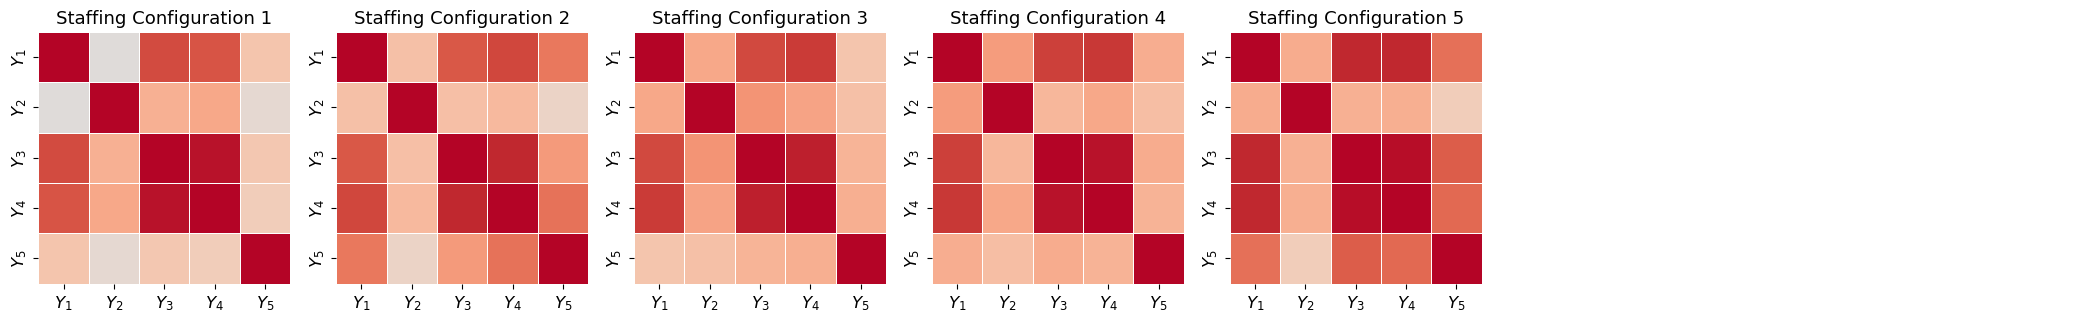

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already defined
df_system_test = df[df['cluster'] == 1]
df_system_test = df_system_test.reset_index(drop=True)
df_system_test['id'] = df_system_test.index + 1

# Define labels for the heatmap using correctly formatted LaTeX strings
labels = [r"$Y_{{{}}}$".format(i + 1) for i in range(len(df_system_test['data points real'][0][0]))] 

# Function to calculate the correlation matrix given probabilities and data points as tuples
def calculate_correlation_matrix(probabilities, data_points):
    # Convert data points (list of tuples) to a numpy array
    support_cluster = np.array([list(point) for point in data_points])
    p_vector_cluster = np.array(probabilities)

    # Calculate the weighted mean vector using the provided probabilities
    mean_vector_cluster = np.average(support_cluster, axis=0, weights=p_vector_cluster)

    # Initialize the covariance matrix
    covariance_cluster = np.zeros((support_cluster.shape[1], support_cluster.shape[1]))

    # Compute the covariance matrix using the weighted probability
    for i in range(len(p_vector_cluster)):
        deviation = support_cluster[i] - mean_vector_cluster
        covariance_cluster += p_vector_cluster[i] * np.outer(deviation, deviation)

    # Calculate the covariance matrix
    C = covariance_cluster

    # Calculate the diagonal matrix D (standard deviations)
    D = np.sqrt(np.diag(np.diag(C)))

    # Calculate the inverse of D
    D_inv = np.linalg.inv(D)

    # Calculate the correlation matrix R
    R = np.dot(np.dot(D_inv, C), D_inv)

    return C, R

# Initialize an empty matrix to sum correlation matrices across systems
corr_all = None

# Number of systems to plot
num_systems = len(df_system_test)

# Determine the number of rows and columns for subplots
num_cols = 7  # Set the desired number of columns
num_rows = (num_systems // num_cols) + int(num_systems % num_cols != 0)  # Calculate rows based on total plots

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each system and calculate the correlation matrix
for system_num in range(len(df_system_test)):
    # Define probabilities for the current system's data points
    probabilities = [i/len(df_system_test['data points real'][system_num]) for i in range(len(df_system_test['data points real'][system_num]))]
    data_points = df_system_test['data points real'][system_num]

    # Calculate the covariance and correlation matrices
    covariance_matrix, correlation_matrix = calculate_correlation_matrix(probabilities, data_points)
    
    # Add the correlation matrix to the cumulative sum
    if corr_all is None:
        corr_all = np.copy(correlation_matrix)
    else:
        corr_all += correlation_matrix
    
    # Plot the correlation matrix as a heatmap in the corresponding subplot
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=False, square=True, fmt='.3f', linewidths=.5, vmin=-1, vmax=1,
                xticklabels=labels, yticklabels=labels, ax=axes[system_num], annot_kws={"size": 8})
    
    axes[system_num].set_title(f"Staffing Configuration {system_num + 1}", fontsize=13)
    axes[system_num].tick_params(labelsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=15)

# Hide unused subplots if the number of plots is not a multiple of `num_cols`
for ax in axes[num_systems:]:
    ax.axis('off')
plt.savefig('../../results/correlation_matrix_cluster_1.png')
# Adjust layout
plt.tight_layout()
plt.show()
